# Cargar datos

from google.colab import drive
drive.mount('/content/drive')

In [1]:
data_dir = "images/"

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.25  
)

In [3]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',  
    subset='training'  
)

Found 9570 images belonging to 32 classes.


In [4]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=512,
    class_mode='categorical',
    subset='validation'  
)

Found 3188 images belonging to 32 classes.


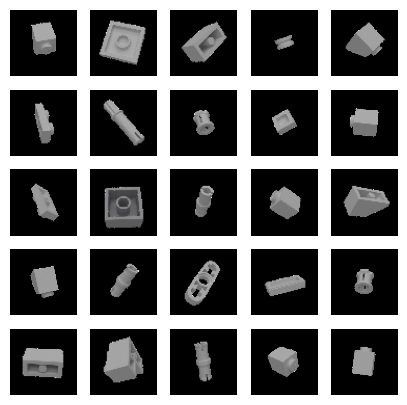

In [5]:
fig, axes = plt.subplots(5, 5, figsize=(5, 5))


for i in range(5):
    for j in range(5):

        batch = next(train_generator)
        images, _ = batch


        ax = axes[i, j]
        ax.imshow(images[0]) 
        ax.axis('off') 

# Deep Learning

Aplanar los datos de entrada y ordenarlos en una matriz es muy demorado, por eso hay un limitador dentro de cada for que permite cargar solo una parte de los datos

In [6]:
modelo = Sequential([
    Dense(128, input_shape=(64, 64, 3), activation='relu'),
    Dense(64, activation='softmax'),
    Dense(32, activation='relu'),
    Dense(16, activation='softmax'),
    Dense(8, activation='relu'),
    Dense(4, activation='softmax'),
    Flatten()
])


x_train = np.empty((16384))
y_train = np.empty((1))

for i,batch in enumerate(train_generator):
    images, labels = batch
    
    for j,image in enumerate(images):

        output = modelo.layers[0](image)
        output = modelo.layers[1](output)
        output = modelo.layers[2](output)
        output = modelo.layers[3](output)
        output = modelo.layers[4](output)
        output = modelo.layers[5](output)

        flatten_output = modelo.layers[-1](output)
        vector_output = flatten_output.numpy()
        vector_output = vector_output.flatten()

        x_train = np.vstack((x_train, vector_output))
        y_train = np.vstack((y_train, np.where(labels[j] == 1)))


    if(i == 15):
        break

x_test = np.empty((16384))
y_test = np.empty((32))

for i,batch in enumerate(validation_generator):
    images, labels = batch

    for j,image in enumerate(images):

        output = modelo.layers[0](image)
        output = modelo.layers[1](output)
        output = modelo.layers[2](output)
        output = modelo.layers[3](output)
        output = modelo.layers[4](output)
        output = modelo.layers[5](output)

        flatten_output = modelo.layers[-1](output)
        vector_output = flatten_output.numpy()
        vector_output = vector_output.flatten()

        x_test = np.vstack((x_train, vector_output))
        y_test = np.vstack((y_train, np.where(labels[j] == 1)))

    if(i == 2):
        break

In [7]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_test  = y_test.ravel()
y_train = y_train.ravel()
pd.DataFrame(y_test)

,0
0,0
1,1
2,16
3,29
4,2
...,...
509,11
510,16
511,16
512,12


In [8]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

x_train = imputer.fit_transform(x_train)
x_test = imputer.fit_transform(x_test)

## K - Nearest Neighbors

In [9]:
from sklearn.neighbors import KNeighborsClassifier

k_values = np.arange(2, 20)
best_knn_model = None
knn_best_accuracy = 0

train_accuracy = np.empty(len(k_values))
test_accuracy = np.empty(len(k_values))

for i,k in enumerate(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    accuracy = knn.score(x_test,y_test)
    # print("k = %d, accuracy = %.2f%%" % (k, accuracy * 100))
    train_accuracy[i] = knn.score(x_train,y_train)
    test_accuracy[i] = knn.score(x_test,y_test)
    if accuracy > knn_best_accuracy:
        knn_best_accuracy = accuracy
        best_knn_model = knn

print("Best accuracy: %.2f%%" % (knn_best_accuracy * 100))
best_knn_model

Best accuracy: 67.32%


KNeighborsClassifier(n_neighbors=2)

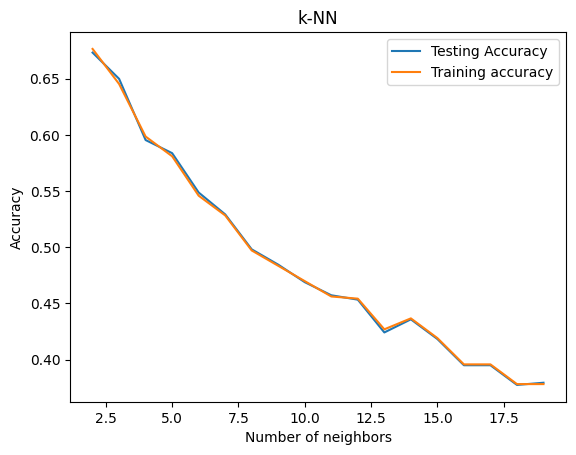

In [10]:
plt.title('k-NN')
plt.plot(k_values, test_accuracy, label='Testing Accuracy')
plt.plot(k_values, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

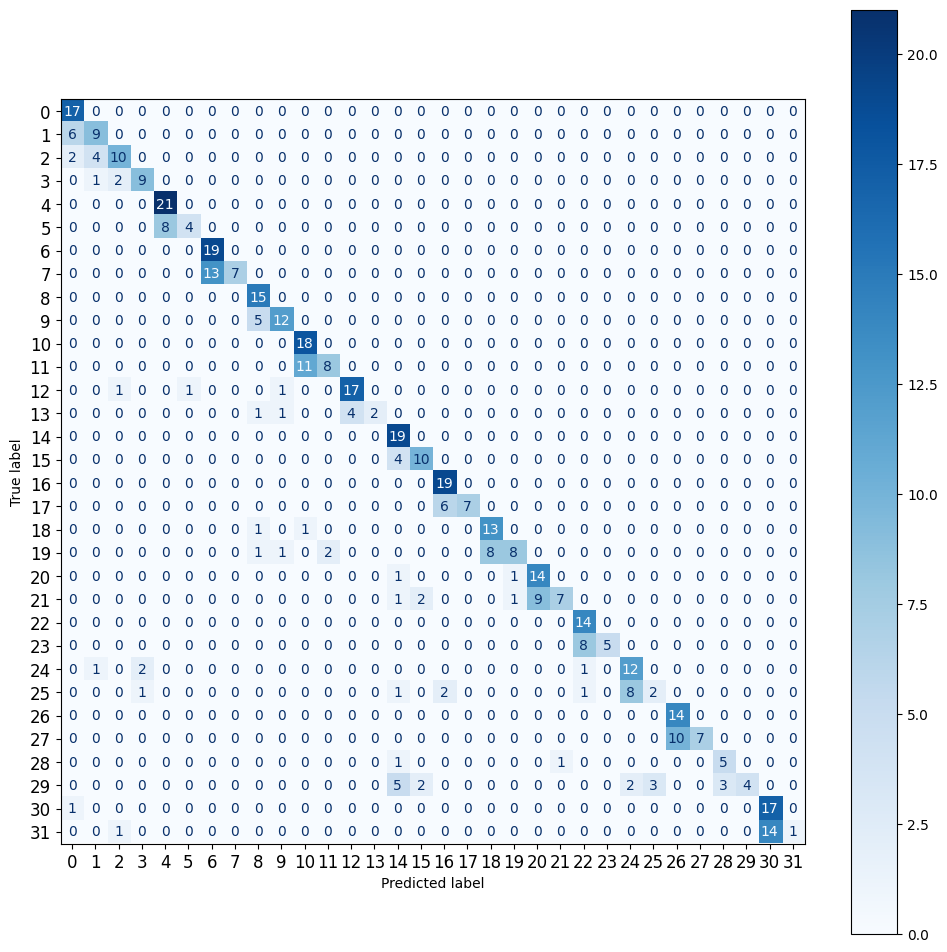

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_knn_model.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Blues, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()

## Red neuronal

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


hidden_layer_sizes = [(100,), (50, 50), (100, 50, 25), (75, 50, 10), (100, 50, 25, 10)]
best_nn_model = None
nn_best_accuracy = 0

for i,hidden_layers in enumerate(hidden_layer_sizes):
    nn = MLPClassifier(hidden_layer_sizes=hidden_layers, solver='adam', activation="relu", random_state=7)
    nn.fit(x_train, y_train)
    y_pred = nn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for Neural Network (hidden layers={hidden_layers}): {accuracy}")
    if accuracy > nn_best_accuracy:
        nn_best_accuracy = accuracy
        best_nn_model = nn


Accuracy for Neural Network (hidden layers=(100,)): 0.042801556420233464
Accuracy for Neural Network (hidden layers=(50, 50)): 0.042801556420233464
Accuracy for Neural Network (hidden layers=(100, 50, 25)): 0.04085603112840467
Accuracy for Neural Network (hidden layers=(75, 50, 10)): 0.04085603112840467
Accuracy for Neural Network (hidden layers=(100, 50, 25, 10)): 0.042801556420233464


In [13]:
print("Best accuracy: %.2f%%" % (nn_best_accuracy * 100))
print("Best Neural Network hidden layers sizes:", best_nn_model.hidden_layer_sizes)

Best accuracy: 4.28%
Best Neural Network hidden layers sizes: (100,)


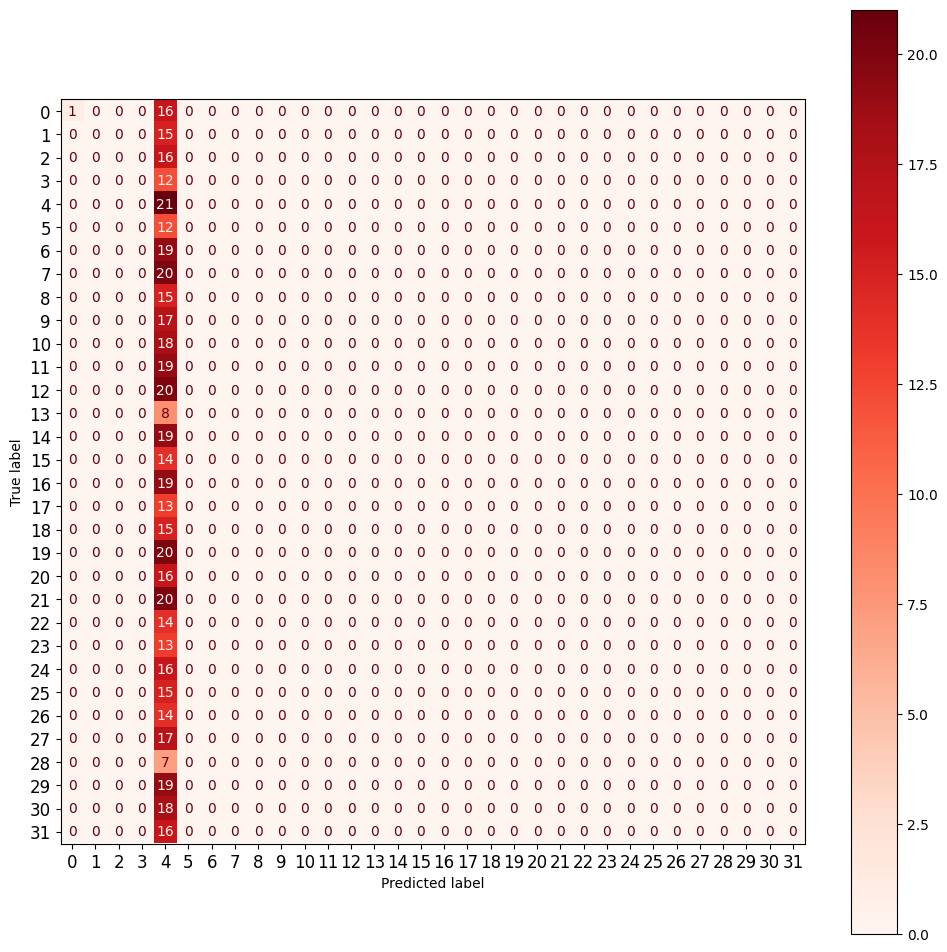

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_nn_model.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Reds, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()


## Support Vector machine

In [15]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for SVM: {svm_accuracy}")

Accuracy for SVM: 0.042801556420233464


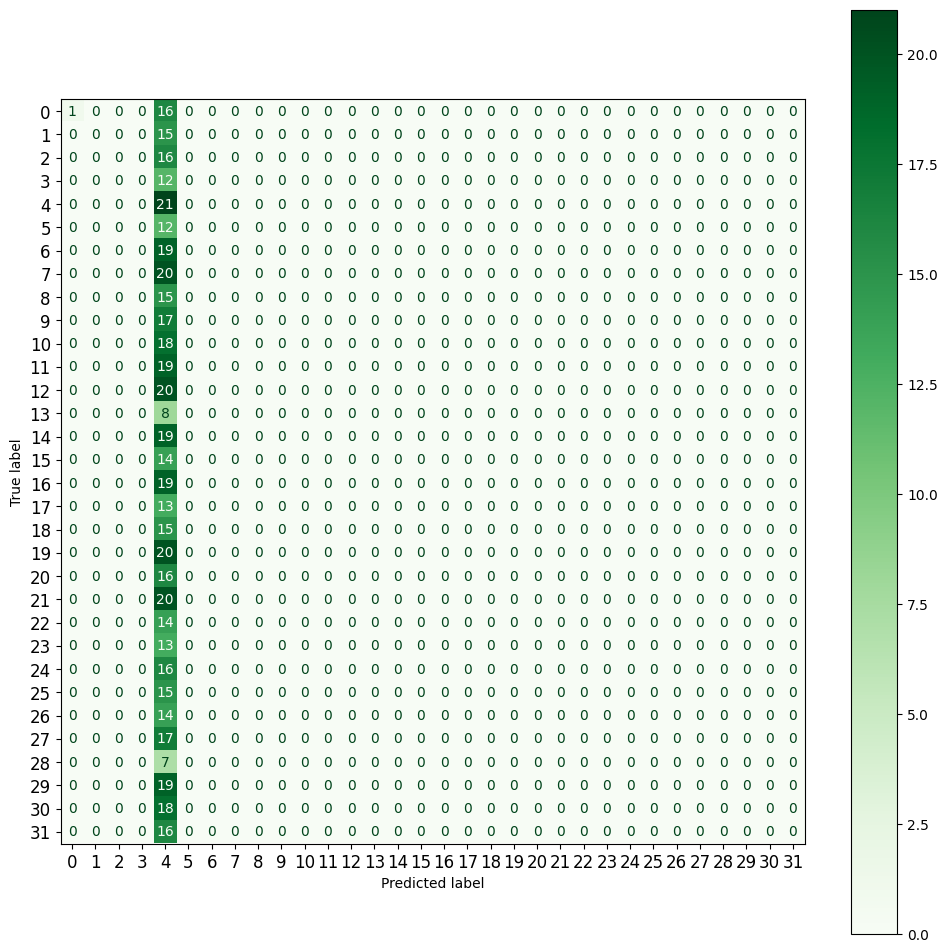

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = svm.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Greens, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()


## Arból de decisión

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)


from sklearn import tree
import graphviz

dtc = tree.DecisionTreeClassifier(random_state=7)
dtc = dtc.fit(x_train_norm, y_train)
y_pred = dtc.predict(x_test_norm)
tree_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Decision Tree: {tree_accuracy}")

Accuracy for Decision Tree: 0.9630350194552529


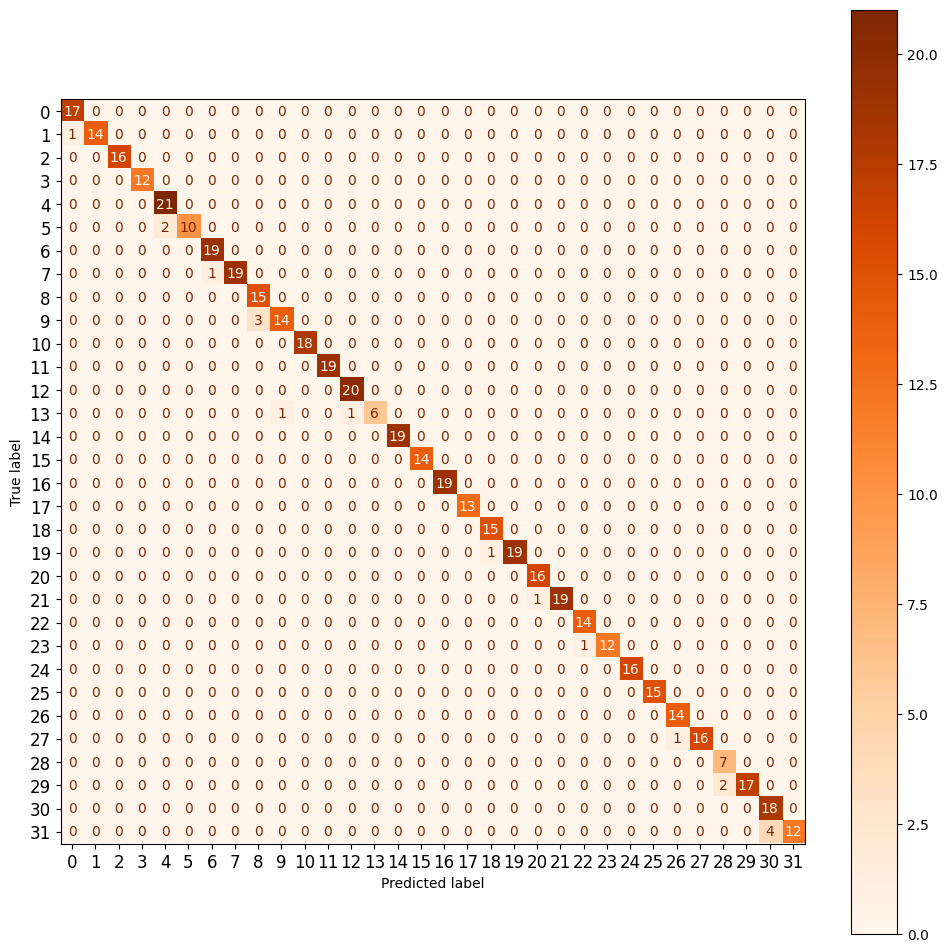

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = dtc.predict(x_test_norm)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Oranges, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()


## Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
gnb_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Naive Bayes: {gnb_accuracy}")

Accuracy for Naive Bayes: 0.7062256809338522


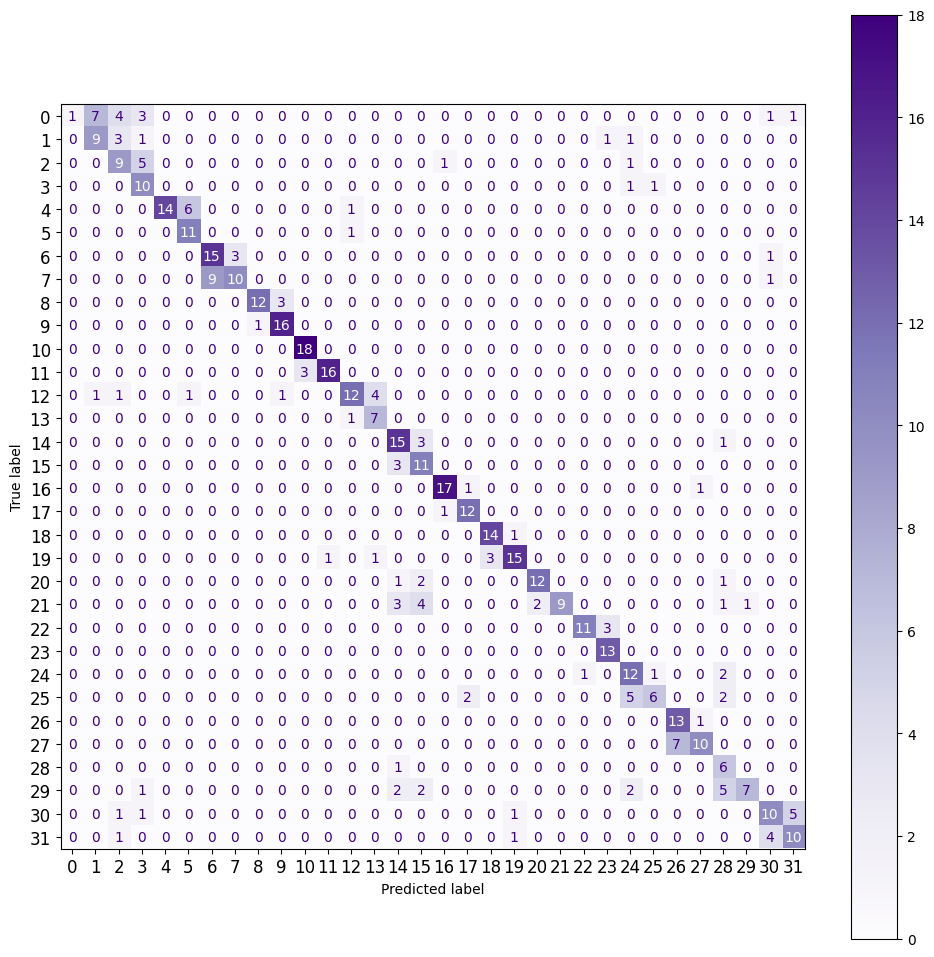

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = gnb.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Purples, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=7)
rfc.fit(x_train_norm, y_train)
y_pred = rfc.predict(x_test_norm)
rfc_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Random Forest: {rfc_accuracy}")

Accuracy for Random Forest: 0.9630350194552529


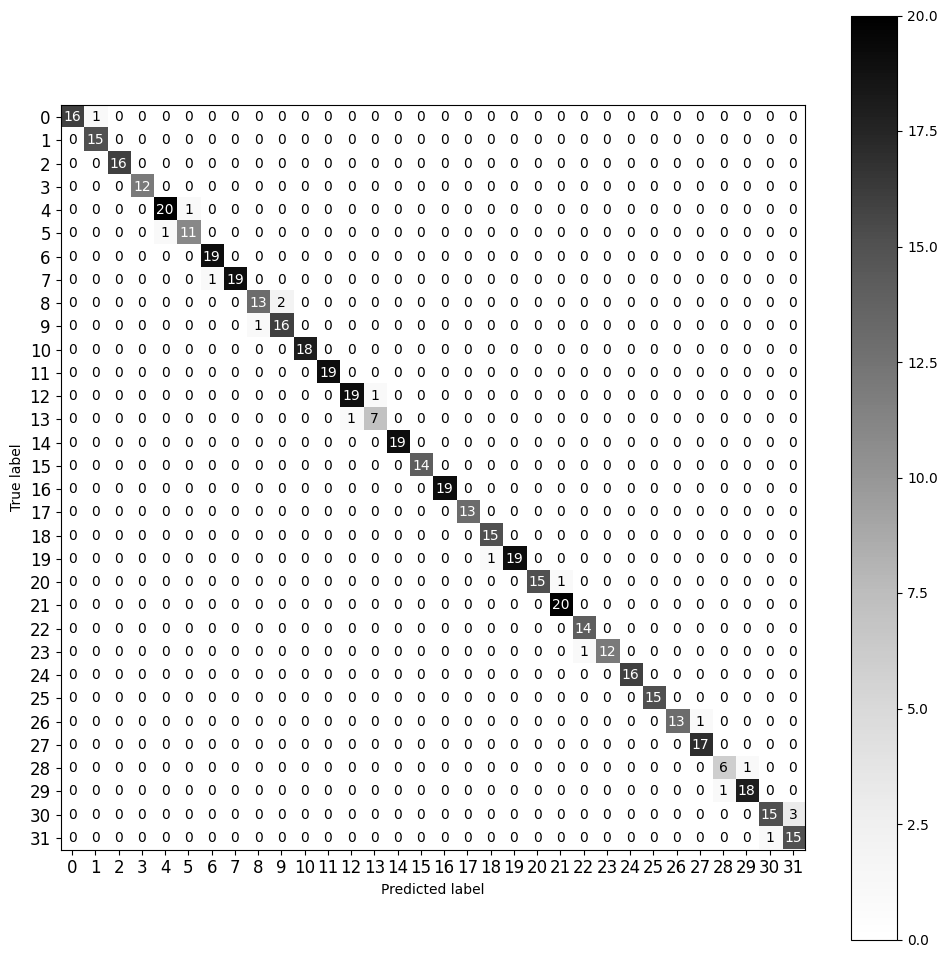

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = rfc.predict(x_test_norm)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Greys, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()

## AdaBoost

In [23]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(random_state=7)
abc.fit(x_train_norm, y_train)
y_pred = abc.predict(x_test_norm)
abc_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for AdaBoost: {abc_accuracy}")

Accuracy for AdaBoost: 0.07003891050583658


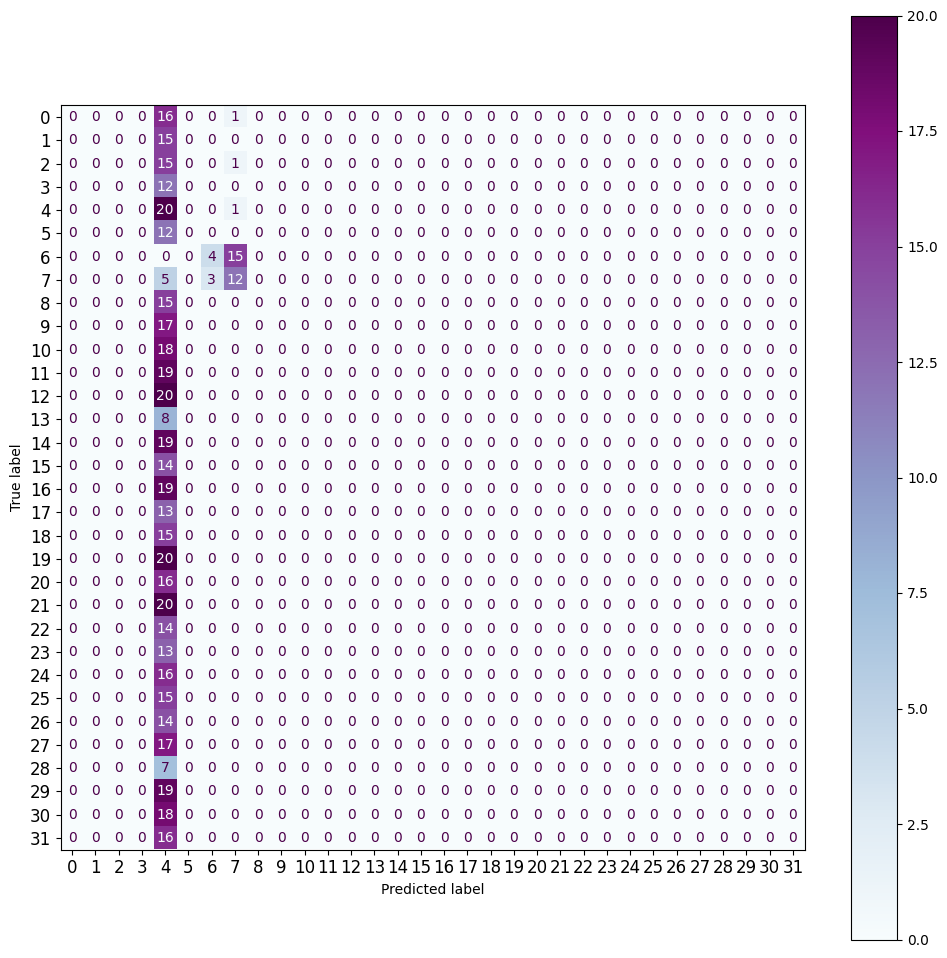

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = abc.predict(x_test_norm)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.BuPu, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()

## Gradient Boosting **(Demora mucho)**

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=7)
gbc.fit(x_train_norm, y_train)
y_pred = gbc.predict(x_test_norm)
gbc_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Gradient Boosting: {gbc_accuracy}")

Accuracy for Gradient Boosting: 0.9630350194552529


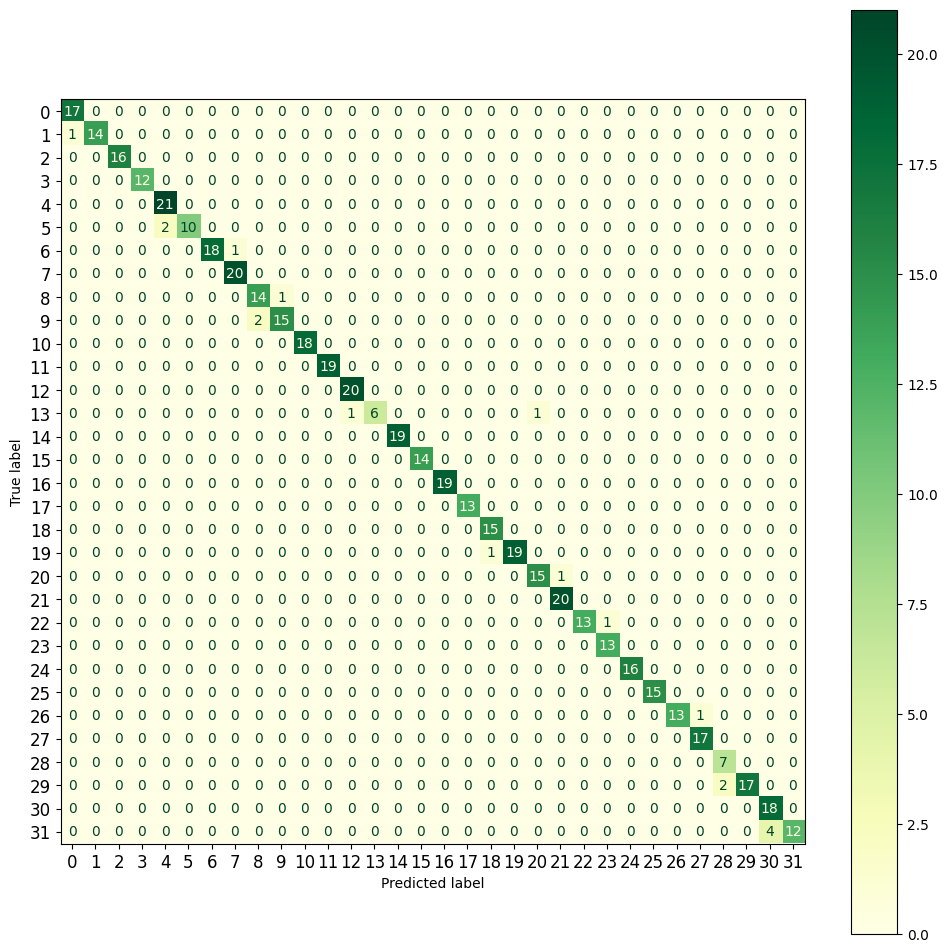

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = gbc.predict(x_test_norm)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_knn_model.classes_)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.YlGn, ax=ax)

disp.ax_.set_xticklabels(disp.ax_.get_xmajorticklabels(), fontsize=12)
disp.ax_.set_yticklabels(disp.ax_.get_ymajorticklabels(), fontsize=12)

plt.show()

## Resultados

In [30]:
print(f"Accuracy for k-NN: {knn_best_accuracy*100}")
print(f"Accuracy for Neural Network: {nn_best_accuracy*100}")
print(f"Accuracy for SVM: {svm_accuracy*100}")
print(f"Accuracy for Decision Tree: {tree_accuracy*100}")
print(f"Accuracy for Naive Bayes: {gnb_accuracy*100}")
print(f"Accuracy for Random Forest: {rfc_accuracy*100}")
print(f"Accuracy for AdaBoost: {abc_accuracy*100}")
print(f"Accuracy for Gradient Boosting: {gbc_accuracy*100}")

Accuracy for k-NN: 67.31517509727627
Accuracy for Neural Network: 4.280155642023346
Accuracy for SVM: 4.280155642023346
Accuracy for Decision Tree: 96.3035019455253
Accuracy for Naive Bayes: 70.62256809338521
Accuracy for Random Forest: 96.3035019455253
Accuracy for AdaBoost: 7.003891050583658
Accuracy for Gradient Boosting: 96.3035019455253
